In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import warnings
# nltk.download('stopwords', quiet=True)
# nltk.download('wordnet', quiet=True)
# nltk.download('omw-1.4', quiet=True)
warnings.filterwarnings("ignore")

In [2]:
ls

01_data_ingestion.ipynb       03_data_transformation.ipynb
02_data_validation.ipynb      trials.ipynb


In [3]:
cd ..

/Users/gojuruakshith/YouTube-Fake-Thumbnail-Detector


In [27]:
ls

123/                                bootstrap/
Akashpro/                           c program/
Akashpro copy/                      cart/
Applications/                       chat application/
CLASS REACT/                        crypto-tracker/
CSC317/                             csc-317/
Calculator.js/                      dashboardReactjs/
Desktop/                            dfjk/
Documents/                          finalproject/
Downloads/                          finalproject-1/
FinalProject-2/                     lastest/
FinalProject-3/                     my-react-app/
FinalProject-4/                     myntra/
Langchain/                          new/
Library/                            nk/
MLops_project/                      nltk_data/
Movies/                             node/
Music/                              os pratice/
NKYOUTH/                            os project/
Netflix/                            practise sheet /
New react/                          python.py
Pictures/  

In [28]:
cd YouTube-Fake-Thumbnail-Detector/

/Users/gojuruakshith/YouTube-Fake-Thumbnail-Detector


In [22]:
from dataclasses import dataclass
@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir:Path
    data_dir:Path

In [23]:
from src.mlProject.utils.common import read_yaml,create_directories
from src.mlProject.constants import *
class ConfigurationManager:
    def __init__(self):
        self.config = read_yaml(CONFIG_FILE_PATH)
        self.params = read_yaml(PARAM_FILE_PATH)
        self.schema = read_yaml(SCHEMA_FILE_PATH)
    def get_data_transformation_config(self)->DataTransformationConfig:
        config = self.config.data_transformation
        create_directories([Path(config.root_dir)])
        data_transformation_config = DataTransformationConfig(
            root_dir=config.root_dir,
            data_dir=config.data_path,
        )
        return data_transformation_config

In [6]:
df = pd.read_csv("artifacts/data_ingestion/youtube_dataset.csv")
df.shape

(32000, 2)

In [7]:
df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [26]:
class DataTransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config
        data_path = self.config.data_dir

        self.data = pd.read_csv(data_path)

        create_directories([self.config.root_dir])

        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def data_information(self):
        data_dtype_info = pd.DataFrame(self.data.dtypes).rename(columns={0: "DataType"})
        data_null_info = pd.DataFrame(self.data.isnull().sum()).rename(columns={0: "Null Value Count"})
        data_total_info = pd.concat([data_dtype_info, data_null_info], axis=1)
        return data_total_info

    def figure_1(self, data_total_info: pd.DataFrame):
        plt.figure(figsize=(8, 4))
        plt.title("Null Value Count")
        plt.xlabel("COLUMN NAMES")
        plt.ylabel("COUNT OF NULL VALUES")
        plt.ylim(bottom=0)
        plt.bar(x=data_total_info.index.astype(str), height=data_total_info["Null Value Count"].values)
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    def figure_2(self, df: pd.DataFrame):
        from collections import Counter

        def length_counter(series):
            counter = Counter()
            for text in series.fillna("").astype(str):
                l = len(text)
                if l < 20:
                    counter["Less Than 20"] += 1
                elif l < 30:
                    counter["Less Than 30"] += 1
                else:
                    counter["40 or More"] += 1
            return counter

        counts = length_counter(df["headline"])

        plt.figure(figsize=(7, 4))
        plt.title("Titles Classification Based On Length")
        plt.xlabel("CLASSIFICATION TYPE")
        plt.ylabel("COUNT")
        plt.ylim(bottom=0)
        plt.bar(list(counts.keys()), list(counts.values()))
        plt.tight_layout()
        plt.show()

    def data_preprocessing(self, text: str) -> str:
        if not isinstance(text, str) or not text.strip():
            return ""

        text = text.lower()
        text = re.sub(r"[^a-zA-Z\s]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()

        tokens = word_tokenize(text)
        tokens = [w for w in tokens if w not in self.stop_words and len(w) > 2]
        tokens = [self.lemmatizer.lemmatize(w) for w in tokens]

        return " ".join(tokens)

    def data_selection(self):
        data_information = self.data_information()
        self.figure_1(data_information)
        self.figure_2(self.data)

        df = self.data.copy()
        df["headline"] = df["headline"].fillna("").astype(str)
        df["headline"] = df["headline"].apply(self.data_preprocessing)

        X = df["headline"]
        y = df["clickbait"]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        train_df = pd.DataFrame({"headline": X_train, "class": y_train})
        test_df = pd.DataFrame({"headline": X_test, "class": y_test})

        train_df.to_csv(os.path.join(self.config.root_dir, "train.csv"), index=False)
        test_df.to_csv(os.path.join(self.config.root_dir, "test.csv"), index=False)

        return train_df, test_df

[2026-01-07 14:04:23,304: INFO: common: YAML file loaded successfully: config/config.yaml]
[2026-01-07 14:04:23,306: INFO: common: YAML file loaded successfully: params.yaml]
[2026-01-07 14:04:23,307: INFO: common: YAML file loaded successfully: schema.yaml]
[2026-01-07 14:04:23,308: INFO: common: Created directory at: artifacts/data_transformation]
[2026-01-07 14:04:23,336: INFO: common: Created directory at: artifacts/data_transformation]


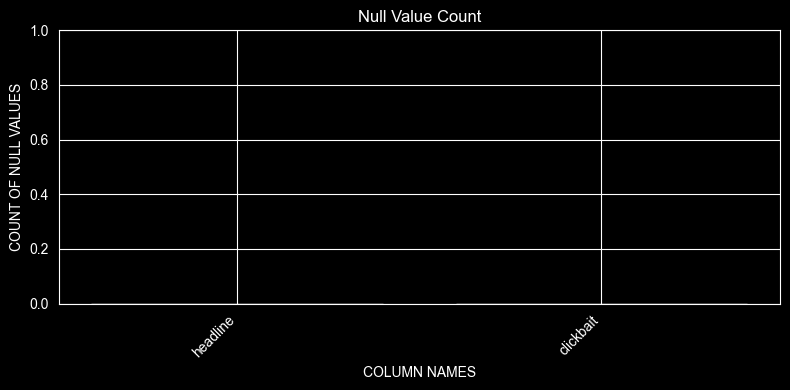

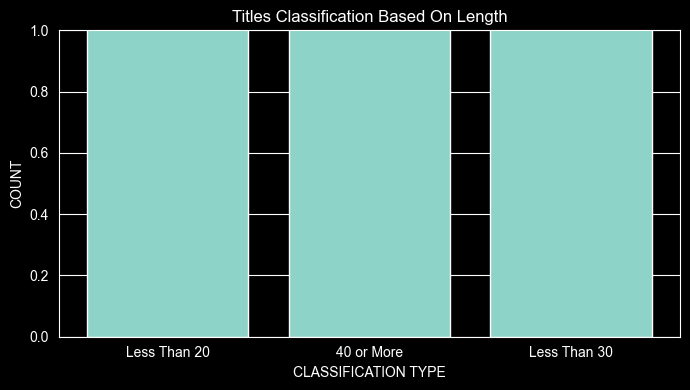

In [27]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = DataTransformation(config=data_transformation_config)
    data_transformation.data_information()
    data_transformation.data_selection()
except Exception as e:
    raise e